## **Problem research**
Home credit adalah perusahaan pembiyaan yang menghadapi credit risk, yaitu risiko nasabah gagal dalam membayar pinjaman.

**Tujuan:**
Bagaimana memprediksi kemungkinan seorang applicant akan gagal bayar sejak awal pengajuan, agar perusahaan dapat menekan kerugian, mengurangi NPL(Non-performing load), dan tetap menjaga pertumbuhan bisnis.

**Import Library**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

**Load Data/Upload Data**

In [2]:
from google.colab import files
uploaded = files.upload()

Saving application_test.csv to application_test.csv
Saving application_train.csv to application_train.csv


Dataset **`application_train.csv`** berisi data pengajuan pinjaman nasabah Home Credit.

In [3]:
df_train = pd.read_csv("application_train.csv")
print(df_train.shape)
df_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Setiap baris merepresentasikan **satu aplikasi pinjaman**, sementara kolom-kolomnya berisi informasi:
- Demografi nasabah
- Kondisi finansial
- Riwayat administratif
- Informasi eksternal (credit scoring)

Target utama pada dataset ini adalah kolom **TARGET**, di mana:
- TARGET = 1 → Nasabah gagal bayar  
- TARGET = 0 → Nasabah tidak gagal bayar

Dataset terdiri dari:
- 307.511 baris data
- 122 kolom fitur

**Informasi dataset, dan cek missing values**

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [5]:
missing = (df_train.isna().mean() * 100).sort_values(ascending=False)
missing.head(20)

,0
COMMONAREA_AVG,69.872297
COMMONAREA_MODE,69.872297
COMMONAREA_MEDI,69.872297
NONLIVINGAPARTMENTS_MEDI,69.432963
NONLIVINGAPARTMENTS_MODE,69.432963
NONLIVINGAPARTMENTS_AVG,69.432963
FONDKAPREMONT_MODE,68.386172
LIVINGAPARTMENTS_AVG,68.354953
LIVINGAPARTMENTS_MEDI,68.354953
LIVINGAPARTMENTS_MODE,68.354953


Pada tahap ini, kita menghitung persentase missing value pada setiap kolom.

Hasil analisis menunjukkan bahwa beberapa fitur (terutama yang berkaitan dengan properti rumah) memiliki missing value lebih dari 60%.

Hal ini bukan kesalahan data, melainkan mencerminkan kondisi bisnis:
- Tidak semua nasabah memiliki rumah
- Tidak semua informasi properti terdokumentasi

**Memisahkan kolom numeric dan kategorial**

In [6]:
target_col = "TARGET"

cat_cols = df_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = df_train.select_dtypes(exclude=["object"]).columns.tolist()

# buang target dari list numerik
if target_col in num_cols:
    num_cols.remove(target_col)

print("Jumlah kolom kategorikal:", len(cat_cols))
print("Jumlah kolom numerik:", len(num_cols))

Jumlah kolom kategorikal: 16
Jumlah kolom numerik: 105



Kolom numerik dan kategorikal dipisahkan karena membutuhkan perlakuan preprocessing yang berbeda.

- Fitur numerik → imputasi menggunakan median  
- Fitur kategorikal → imputasi menggunakan modus (nilai paling sering muncul)

**Exploratory Data Analysis** (EDA): Distribusi Target

In [7]:
df_train[target_col].value_counts(), df_train[target_col].value_counts(normalize=True)

(TARGET
 0    282686
 1     24825
 Name: count, dtype: int64,
 TARGET
 0    0.919271
 1    0.080729
 Name: proportion, dtype: float64)

Analisis distribusi TARGET menunjukkan bahwa dataset:
- ±92% data merupakan non-default
- ±8% data merupakan default

**Plot distribusi Target**

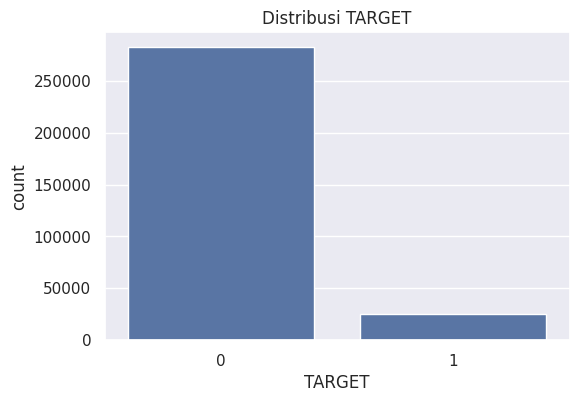

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(x=target_col, data=df_train)
plt.title("Distribusi TARGET")
plt.show()

**Drop kolom yang tidak digunakan**

In [9]:
df = df_train.copy()

if "SK_ID_CURR" in df.columns:
    df.drop(columns=["SK_ID_CURR"], inplace=True)

print(df.shape)

(307511, 121)



Kolom `SK_ID_CURR` merupakan unique identifier yang tidak mengandung informasi prediktif.

**Menangani missing value**

In [10]:
df_imputed = df.copy()

for c in num_cols:
    if c in df_imputed.columns and df_imputed[c].isna().any():
        df_imputed[c] = df_imputed[c].fillna(df_imputed[c].median())

for c in cat_cols:
    if c in df_imputed.columns and df_imputed[c].isna().any():
        df_imputed[c] = df_imputed[c].fillna(df_imputed[c].mode()[0])

df_imputed.isna().sum().sort_values(ascending=False).head(10)

,0
TARGET,0
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
CNT_CHILDREN,0
AMT_INCOME_TOTAL,0
AMT_CREDIT,0
AMT_ANNUITY,0
AMT_GOODS_PRICE,0


**Handle outlier numerik**

In [13]:
def cap_outliers_iqr(series, k=1.5):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return series.clip(lower, upper)

df_out = df_imputed.copy()

for c in num_cols:
    if c in df_out.columns:
        df_out[c] = cap_outliers_iqr(df_out[c])


df_out.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
TARGET,307511.0,0.080729,0.272419,0.0,0.0,0.0,0.0,1.0
CNT_CHILDREN,307511.0,0.407455,0.683742,0.0,0.0,0.0,1.0,2.5
AMT_INCOME_TOTAL,307511.0,162626.947877,73303.150927,25650.0,112500.0,147150.0,202500.0,337500.0
AMT_CREDIT,307511.0,592313.037054,380316.240537,45000.0,270000.0,513531.0,808650.0,1616625.0
AMT_ANNUITY,307511.0,26797.657150,13281.285661,1615.5,16524.0,24903.0,34596.0,61704.0



Outlier ditangani menggunakan metode Interquartile Range (IQR) dengan cara melakukan capping (pembatasan nilai).

**Encoding data kategorikal**

In [14]:
df_encoded = pd.get_dummies(df_out, columns=cat_cols, drop_first=True)
print(df_encoded.shape)
df_encoded.head()

(307511, 229)


,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes
0,1,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,...,False,False,False,False,False,False,False,True,False,False
1,0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,...,False,False,False,False,False,False,False,False,False,False
2,0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,...,False,False,False,False,False,False,True,False,False,False
3,0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,...,False,False,False,False,False,False,True,False,False,False
4,0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,...,False,False,False,False,False,False,True,False,False,False


Fitur kategorikal diubah menjadi numerik menggunakan One-Hot Encoding.

Parameter `drop_first=True` digunakan untuk mencegah multikolinearitas, terutama pada Logistic Regression.

**Feature selection**

In [15]:
corr = df_encoded.corr(numeric_only=True)
cor_target = corr[target_col].abs().sort_values(ascending=False)

cor_target.head(25)

,TARGET
TARGET,1.000000
EXT_SOURCE_2,0.160295
EXT_SOURCE_3,0.155178
DAYS_BIRTH,0.078239
NAME_INCOME_TYPE_Working,0.057481
NAME_EDUCATION_TYPE_Higher education,0.056593
DAYS_LAST_PHONE_CHANGE,0.055236
CODE_GENDER_M,0.054713
DAYS_ID_PUBLISH,0.051457
NAME_EDUCATION_TYPE_Secondary / secondary special,0.049824


Fitur dipilih berdasarkan nilai korelasi absolut terhadap TARGET dengan threshold tertentu.

Hasilnya, jumlah fitur berkurang drastis menjadi hanya fitur-fitur yang paling relevan secara statistik.

**Ambil fitur relevan (threshold)**

In [16]:
threshold = 0.04
selected_features = cor_target[cor_target > threshold].index.tolist()

if target_col not in selected_features:
    selected_features = [target_col] + selected_features

print("Jumlah fitur terpilih:", len(selected_features))
selected_features[:30]

Jumlah fitur terpilih: 14


['TARGET',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Higher education',
 'DAYS_LAST_PHONE_CHANGE',
 'CODE_GENDER_M',
 'DAYS_ID_PUBLISH',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'NAME_INCOME_TYPE_Pensioner',
 'ORGANIZATION_TYPE_XNA',
 'FLAG_DOCUMENT_3',
 'DAYS_REGISTRATION']

**Dataset final hasil seleksi**

In [17]:
df_final = df_encoded[selected_features].copy()
df_final.shape

(307511, 14)

**Split data train dan test**

In [18]:
X = df_final.drop(columns=[target_col])
y = df_final[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((246008, 13), (61503, 13))

Dataset dibagi menjadi data latih dan data uji dengan rasio 80:20.

**Oversampling SMOTE**

- Model dapat belajar pola default dengan lebih baik
- Risiko bias terhadap kelas mayoritas berkurang

In [19]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Sebelum SMOTE:", y_train.value_counts(normalize=True))
print("\nSesudah SMOTE:", y_train_res.value_counts(normalize=True))

Sebelum SMOTE: TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

Sesudah SMOTE: TARGET
0    0.5
1    0.5
Name: proportion, dtype: float64


**Feature Scaling**

In [20]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled  = scaler.transform(X_test)


StandardScaler digunakan untuk menormalkan fitur numerik.

# **Model building**

**Logistic regression**

In [21]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train_res)

pred_lr = logreg.predict(X_test_scaled)
proba_lr = logreg.predict_proba(X_test_scaled)[:,1]

print("Confusion Matrix (LR):\n", confusion_matrix(y_test, pred_lr))
print("\nClassification Report (LR):\n", classification_report(y_test, pred_lr))
print("ROC AUC (LR):", roc_auc_score(y_test, proba_lr))

Confusion Matrix (LR):
 [[44607 11931]
 [ 2635  2330]]

Classification Report (LR):
               precision    recall  f1-score   support

           0       0.94      0.79      0.86     56538
           1       0.16      0.47      0.24      4965

    accuracy                           0.76     61503
   macro avg       0.55      0.63      0.55     61503
weighted avg       0.88      0.76      0.81     61503

ROC AUC (LR): 0.6811270495577357


Model dievaluasi menggunakan:
- Confusion Matrix
- Classification Report
- ROC-AUC Score

**Random forest**
digunakan sebagai pembanding karena mampu menangkap hubungan non-linear.

In [22]:
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train_res, y_train_res)

pred_rf = rf.predict(X_test)
proba_rf = rf.predict_proba(X_test)[:,1]

print("Confusion Matrix (RF):\n", confusion_matrix(y_test, pred_rf))
print("\nClassification Report (RF):\n", classification_report(y_test, pred_rf))
print("ROC AUC (RF):", roc_auc_score(y_test, proba_rf))

Confusion Matrix (RF):
 [[50437  6101]
 [ 3702  1263]]

Classification Report (RF):
               precision    recall  f1-score   support

           0       0.93      0.89      0.91     56538
           1       0.17      0.25      0.20      4965

    accuracy                           0.84     61503
   macro avg       0.55      0.57      0.56     61503
weighted avg       0.87      0.84      0.85     61503

ROC AUC (RF): 0.6769610361425946


**Ringkasan hasil dari kedua model**

In [29]:
results = pd.DataFrame([
    ["Logistic Regression", roc_auc_score(y_test, proba_lr)],
    ["Random Forest", roc_auc_score(y_test, proba_rf)],
], columns=["Model", "ROC_AUC"]).sort_values("ROC_AUC", ascending=False)

results

,Model,ROC_AUC
0,Logistic Regression,0.681127
1,Random Forest,0.676961


Metric utama yang digunakan adalah ROC-AUC karena:
- Lebih robust pada data tidak seimbang
- Mengukur kemampuan model membedakan kelas default dan non-default

Hasil evaluasi menunjukkan bahwa Logistic Regression memiliki performa yang sedikit lebih baik dibanding Random Forest.

**Feature importance dari Random Forest**

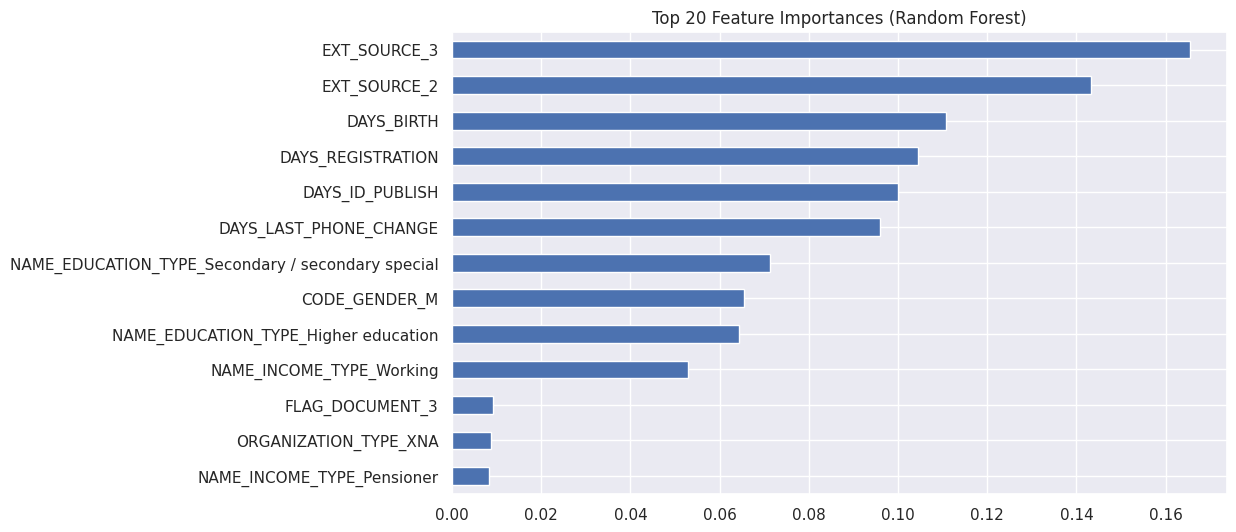

,0
EXT_SOURCE_3,0.165453
EXT_SOURCE_2,0.143162
DAYS_BIRTH,0.110775
DAYS_REGISTRATION,0.104442
DAYS_ID_PUBLISH,0.099918
DAYS_LAST_PHONE_CHANGE,0.095934
NAME_EDUCATION_TYPE_Secondary / secondary special,0.071281
CODE_GENDER_M,0.065528
NAME_EDUCATION_TYPE_Higher education,0.064331
NAME_INCOME_TYPE_Working,0.052939


In [24]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
importances.head(20).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (Random Forest)")
plt.show()

importances.head(20)

Fitur paling berpengaruh terhadap risiko gagal bayar adalah:
- EXT_SOURCE_2
- EXT_SOURCE_3
- DAYS_BIRTH
- DAYS_REGISTRATION

Hal ini menunjukkan bahwa:
- Skor kredit eksternal sangat penting
- Faktor usia dan histori administrasi berperan besar dalam risiko kredit

# Prediksi menggunakan application_test.csv

**Load application_test**

In [25]:
df_test = pd.read_csv("application_test.csv")

if "SK_ID_CURR" in df_test.columns:
    id_test = df_test["SK_ID_CURR"].copy()
    df_test = df_test.drop(columns=["SK_ID_CURR"])
else:
    id_test = None

df_test.shape

(48744, 120)

**Terapkan preprocessing yang sama (impute + outlier cap + onehot + pilih fitur)**

In [26]:
for c in df_test.select_dtypes(exclude=["object"]).columns:
    if df_test[c].isna().any():
        df_test[c] = df_test[c].fillna(df_test[c].median())

for c in df_test.select_dtypes(include=["object"]).columns:
    if df_test[c].isna().any():
        df_test[c] = df_test[c].fillna(df_test[c].mode()[0])

# outlier
for c in df_test.select_dtypes(exclude=["object"]).columns:
    df_test[c] = cap_outliers_iqr(df_test[c])

# onehot
df_test_enc = pd.get_dummies(df_test, drop_first=True)

# samakan kolom dengan train
df_test_enc = df_test_enc.reindex(columns=X.columns, fill_value=0)

df_test_enc.shape

(48744, 13)

**Prediksi pakai model RF**

In [30]:
pred_test = rf.predict(df_test_enc)
proba_test = rf.predict_proba(df_test_enc)[:,1]

submission = pd.DataFrame({
    "SK_ID_CURR": id_test if id_test is not None else np.arange(len(pred_test)),
    "TARGET": proba_test
})

submission.head()

,SK_ID_CURR,TARGET
0,100001,0.083333
1,100005,0.636667
2,100013,0.116667
3,100028,0.256667
4,100038,0.886667


Model diterapkan pada dataset `application_test.csv` untuk menghasilkan probabilitas gagal bayar.

Output ini dapat digunakan sebagai:
- Credit scoring
- Decision support system
- Input kebijakan bisnis

**Simpan CSV**

In [28]:
submission.to_csv("submission_home_credit.csv", index=False)
print("Saved: submission_home_credit.csv")

Saved: submission_home_credit.csv
